Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]

In [1]:
import os
import skimage.io as io
import numpy as np

import tensorflow as tf

import wget
import shutil
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
urls = ['http://images.cocodataset.org/zips/train2017.zip', 
        'http://images.cocodataset.org/zips/val2017.zip',
       'http://images.cocodataset.org/annotations/annotations_trainval2017.zip']

for url in urls:
    output = os.path.join('data', url.split('/')[-1])
    filename = wget.download(url, output)
    # if os.path.exists(output):
    #    shutil.move(filename, output)

100% [......................................................................] 252907541 / 252907541

In [10]:
import zipfile, fnmatch

rootPath = r"D:\coco\data"
pattern = '*.zip'
for root, dirs, files in os.walk(rootPath):
    for filename in fnmatch.filter(files, pattern):
        print(os.path.join(root, filename))
        zipfile.ZipFile(os.path.join(root, filename)).extractall(rootPath)

D:\coco\data\annotations_trainval2017.zip
D:\coco\data\train2017.zip
D:\coco\data\val2017.zip


In [12]:
# pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

In [3]:
from pycocotools.coco import COCO

In [4]:
COCO_ROOT = 'data'

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=26.17s)
creating index...
index created!
loading annotations into memory...
Done (t=1.09s)
creating index...
index created!


In [26]:
BATCH_SIZE = 8
IMG_INP_SIZE = 256
EPOCHS = 10

In [27]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=EPOCHS, inp_size=IMG_INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=IMG_INP_SIZE)

In [28]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((IMG_INP_SIZE, IMG_INP_SIZE, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

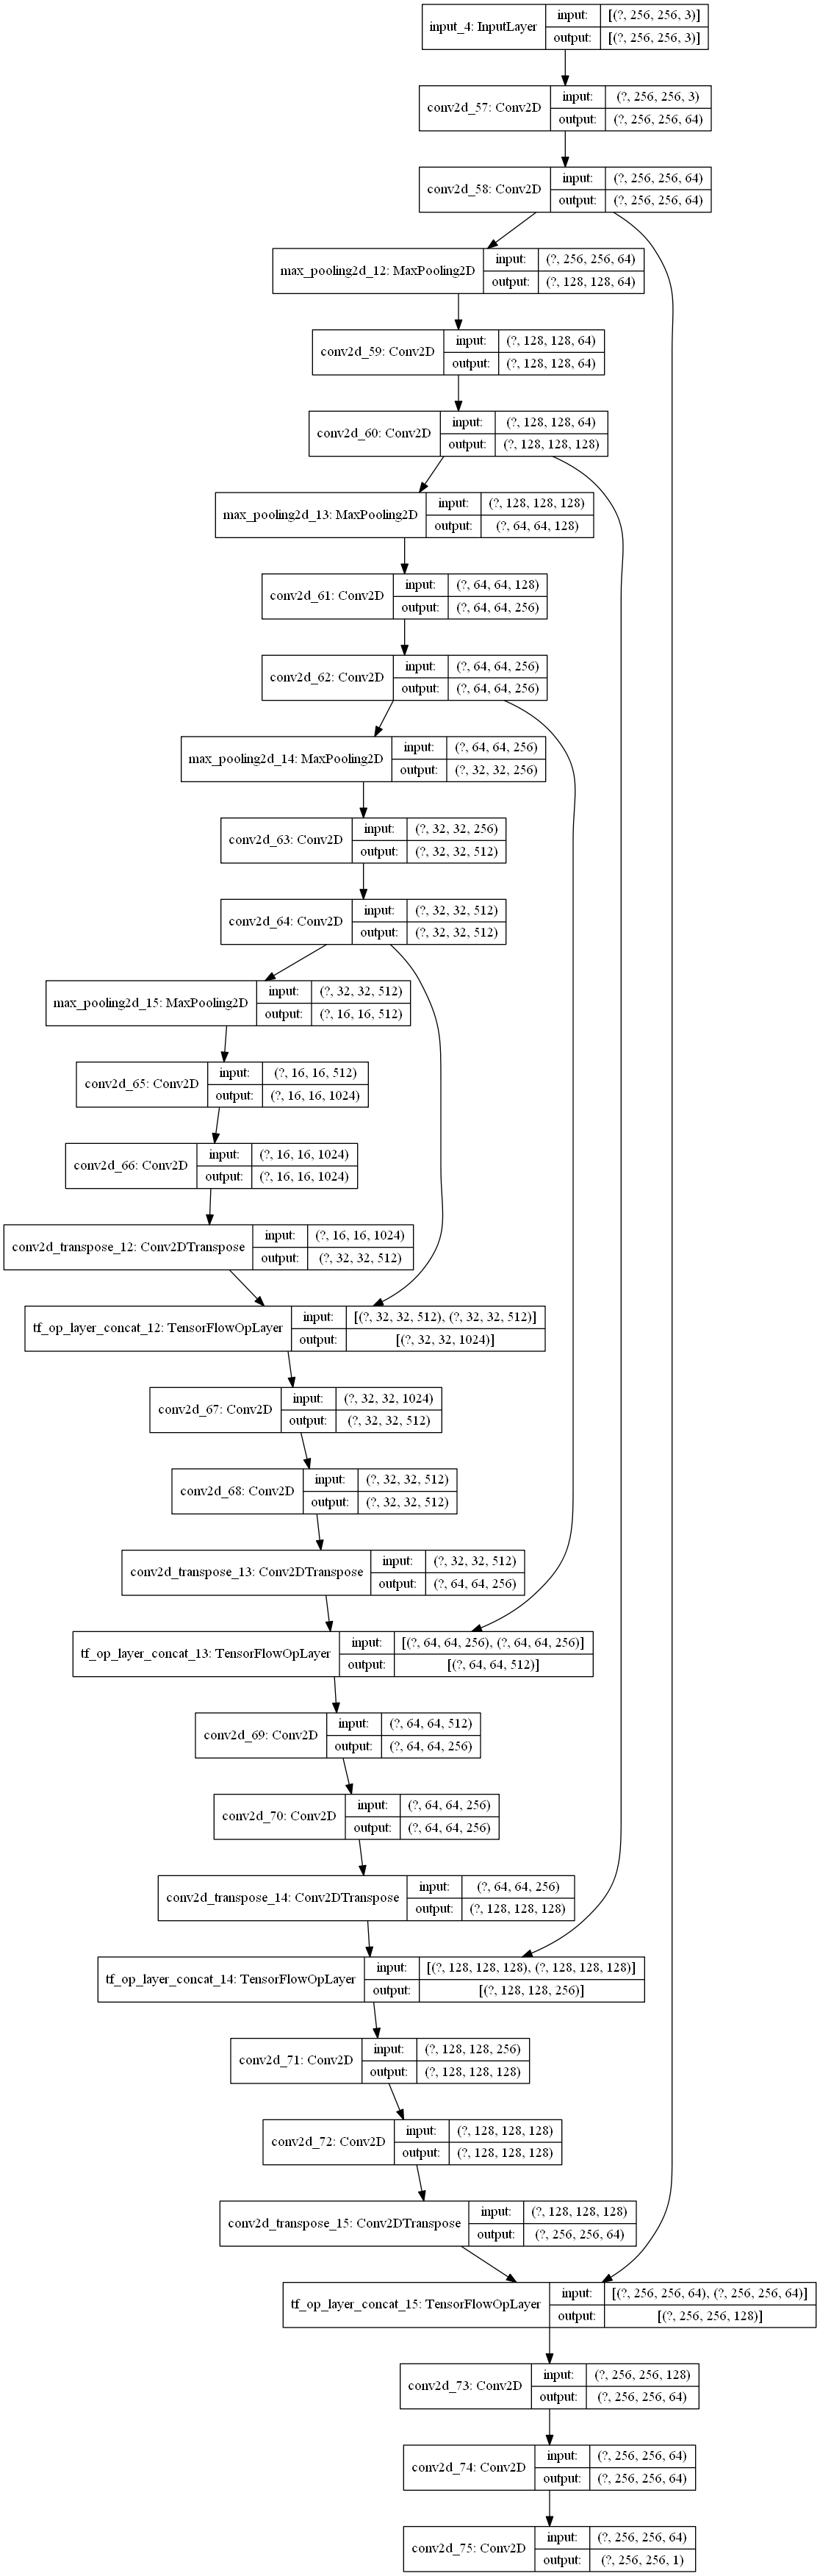

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [30]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

In [33]:
hist = model.fit(train_ds, steps_per_epoch=len(COCO_dataset_train.img_list)//BATCH_SIZE, validation_data=val_ds, epochs=3)

Train for 8014 steps, validate for 336 steps
Epoch 1/3
8014/8014 [==============================] - 5519s 689ms/step - loss: 0.4407 - val_loss: 0.4279
Epoch 2/3
8014/8014 [==============================] - 5493s 685ms/step - loss: 0.3901 - val_loss: 0.3998
Epoch 3/3
8014/8014 [==============================] - 5541s 691ms/step - loss: 0.3746 - val_loss: 0.3960


In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

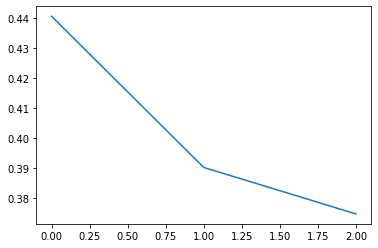

In [53]:
plt.plot(hist.history['loss'])


In [39]:
model.save_weights('hw04_unet_model_weights')

In [48]:
import imageio
from skimage.transform import resize

In [50]:
def prepare_image(img):
    img = img.astype(np.float32)/256.
    img = resize(img, (IMG_INP_SIZE, IMG_INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)


img = imageio.imread('images_donald.jpg', pilmode="RGB")
img = prepare_image(img)

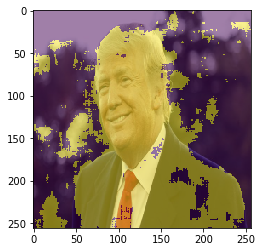

In [54]:
out = model.predict(img[None, ...])
seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
plt.imshow(img*0.5 + seg_map_clr*0.5)
plt.show()

In [55]:
img2 = imageio.imread('images_elon.jpg', pilmode="RGB")
img2 = prepare_image(img2)

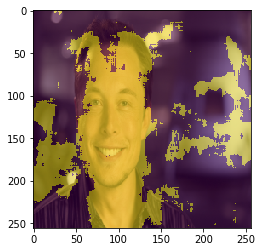

In [56]:
out = model.predict(img2[None, ...])
seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
plt.imshow(img2*0.5 + seg_map_clr*0.5)
plt.show()